In [5]:
import numpy as np
from gym import spaces

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym

In [6]:

class QuadrotorEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(QuadrotorEnv, self).__init__()

        # Constants
        self.g = 9.81  # gravity
        self.m = 1.0   # mass of the UAV
        self.mu = 0.05 # damping factor
        self.dt = 0.02 # time step

        # Define action and observation space
        # Actions are thrust T, angle phi, angle theta
        self.action_space = spaces.Box(low=np.array([0, -np.pi, -np.pi]), 
                                       high=np.array([20, np.pi, np.pi]), dtype=np.float32)

        # Observation space: x, y, z, vx, vy, vz
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # State initialization
        self.state = None
        self.reset()

    def step(self, action):
        T, phi, theta = action
        x, y, z, vx, vy, vz = self.state

        # Calculate accelerations
        ax = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        ay = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        az = self.g - (np.cos(phi) * np.cos(theta)) * T / self.m

        # Update velocities
        vx += (ax - self.mu * vx) * (self.dt)
        vy += (ay - self.mu * vy) * (self.dt)
        vz += (az - self.mu * vz) * (self.dt)

        # Update positions
        x += vx * self.dt
        y += vy * self.dt
        z += vz * self.dt
        


        # Update state
        self.state = np.array([x, y, z, vx, vy, vz])

        # Calculate reward (placeholder)
        reward = -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)
        # reward=0.5* -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)+0.3 * np.sqrt((vx+6 * np.sin(1.2 * self.current_step * self.dt))**2 + (vy-6*np.cos(1.2 * self.current_step * self.dt))**2 + vz**2)
    

        # Check if UAV is within the reasonable bounds (this is a simple check)
        done = z<-50 or self.current_step > 1000

        self.current_step += 1

        # Optionally we could add more info
        info = {}
       
            
            

        return self.state, reward, done, info

    def reset(self):
        # Reset the state
        self.state = np.array([0.0, 0.0, 0.0, 1.0, -1.0, 0.0], dtype=np.float32)
        self.current_step = 0
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f'State: {self.state}')


In [7]:


# Setting up the device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Actor network
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, act_limit):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, act_dim)
        )
        self.act_limit = act_limit

    def forward(self, obs):
        mu = self.net(obs)
        std = torch.clamp(self.net(obs), -20, 2)  # clamp the values of the log std for stability
        dist = Normal(mu, std.exp())
        return dist

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, obs, act):
        return self.net(torch.cat([obs, act], dim=-1))

# SAC Agent
class SACAgent:
    def __init__(self, obs_dim, act_dim, act_limit):
        self.actor = Actor(obs_dim, act_dim, act_limit).to(device)
        self.critic1 = Critic(obs_dim, act_dim).to(device)
        self.critic2 = Critic(obs_dim, act_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=1e-3)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=1e-3)
        self.steps_done = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        dist = self.actor(state)
        action = dist.sample()
        return action.clamp(-self.actor.act_limit, self.actor.act_limit).cpu().detach().numpy()

    def update(self, transition):
        # This method should be filled in with actual SAC update logic
        pass

# Environment setup
env = QuadrotorEnv()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

# Instantiate SAC Agent
agent = SACAgent(obs_dim, act_dim, act_limit)

# Training loop
num_episodes = 1000
for ep in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward
    print(f"Episode: {ep+1}, Reward: {episode_reward}")



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode: 1, Reward: -567384.6921936686
Episode: 2, Reward: -564424.9244928245
Episode: 3, Reward: -565159.203365763
Episode: 4, Reward: -567471.3718731866
Episode: 5, Reward: -566205.252145574
Episode: 6, Reward: -567265.3603001387
Episode: 7, Reward: -566281.4051105371
Episode: 8, Reward: -566323.4961081858
Episode: 9, Reward: -567761.2763239393
Episode: 10, Reward: -565349.2753783322
Episode: 11, Reward: -565501.1662880392
Episode: 12, Reward: -568767.1386214196
Episode: 13, Reward: -564037.5048796837
Episode: 14, Reward: -569762.4927511138
Episode: 15, Reward: -567342.0616880291
Episode: 16, Reward: -568211.7638771195
Episode: 17, Reward: -566420.6148276277
Episode: 18, Reward: -566426.3190875143
Episode: 19, Reward: -565392.9437675179
Episode: 20, Reward: -566189.3849606754
Episode: 21, Reward: -565393.7126340783
Episode: 22, Reward: -567625.2792312314
Episode: 23, Reward: -564963.3101197863
Episode: 24, Reward: -570097.9114216921
Episode: 25, Reward: -570061.204181531
Episode: 26,

Episode: 1, Reward: -568594.8130500908
Episode: 2, Reward: -566979.547971125
Episode: 3, Reward: -564748.0536033005
Episode: 4, Reward: -569010.9760671415
Episode: 5, Reward: -566566.9072632882
Episode: 6, Reward: -567055.5278364944
Episode: 7, Reward: -567091.2152516472
Episode: 8, Reward: -567217.595296471
Episode: 9, Reward: -564952.3526234056
Episode: 10, Reward: -566639.9499308793
Episode: 11, Reward: -567088.6117077811
Episode: 12, Reward: -564686.8594585335
Episode: 13, Reward: -567066.2572561724
Episode: 14, Reward: -570454.492036785
Episode: 15, Reward: -566274.2759308127
Episode: 16, Reward: -566477.1555274334
Episode: 17, Reward: -568279.5650811428
Episode: 18, Reward: -566597.3358015728
Episode: 19, Reward: -565303.4410416752
Episode: 20, Reward: -569984.832451407
Episode: 21, Reward: -567192.0167542305
Episode: 22, Reward: -566307.9747668786
Episode: 23, Reward: -567379.3336361547
Episode: 24, Reward: -566383.3056615187
Episode: 25, Reward: -566973.9675065634
Episode: 26, 

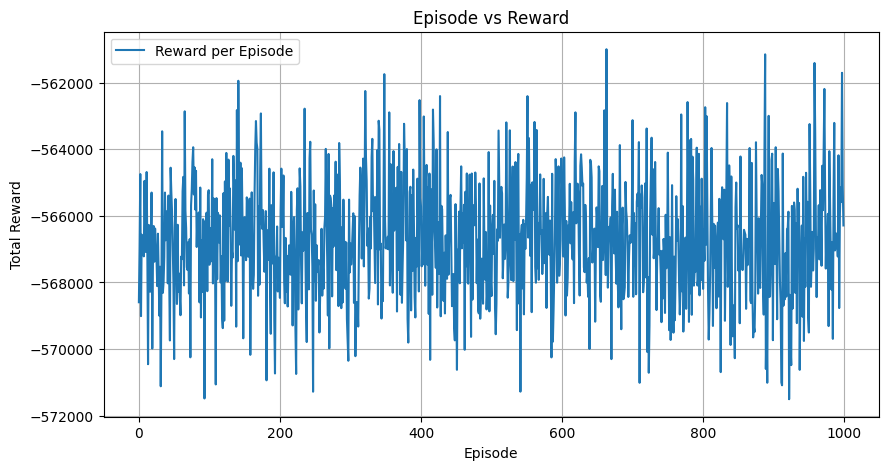

In [11]:
import matplotlib.pyplot as plt

# Initialize the SAC Agent and environment as before

# Training loop parameters
num_episodes = 1000
episode_rewards = []  # To track rewards for each episode

for ep in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        # Assuming the update method is defined and used correctly here
        agent.update((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward
    episode_rewards.append(episode_reward)
    print(f"Episode: {ep+1}, Reward: {episode_reward}")

# After the loop, plot the results
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode vs Reward')
plt.legend()
plt.grid(True)
plt.show()
